In [48]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
# Standard imports
import os
import sys
sys.path.append("../")
sys.path.append("../../")
import math
import json
import torch
import yaml
from collections import Counter


import numpy as np
import pandas as pd
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import pairwise_distances
from scipy.optimize import linear_sum_assignment
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
import src.utils.io as io   
import config as config
import src.utils.preprocess as preprocess



In [2]:
# Graphing Parameters
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

mpl.rcParams['lines.markersize'] = 12
mpl.rcParams['lines.linewidth'] = 1
mpl.rcParams['xtick.labelsize'] = 25
mpl.rcParams['ytick.labelsize'] = 25
mpl.rcParams["axes.labelsize"] = 25
mpl.rcParams['legend.fontsize'] = 20
mpl.rcParams['axes.titlesize'] = 25
mpl.rcParams['text.usetex'] = True

In [3]:
# ----------------------------------------------------------------------------
# CONFIG
# ----------------------------------------------------------------------------
CONFIG = {
# Input files (change these paths to your actual data)
# Accepts: .npy (numpy arrays) or .csv (with 9 feature columns)


# Output
'out_dir': 'output',
'target_labels_out': 'output/target_labels.npy',
'target_label_confidence_out': 'output/target_label_confidence.npy',


# Clustering hyperparams
'n_clusters': 100,
'random_state': 42,


# MiniBatch params important for scalability
'mbk_batch_size': 10000, # size of minibatches when fitting target clustering
'mbk_max_iter': 100, # maximum number of iterations (calls to partial_fit) over the dataset


# Assignment rules
'purity_threshold': 0.6, # only propagate label if source cluster has purity >= this
'allow_all_labels': True, # if False, label as -1 when purity < threshold


# Preprocessing
'standardize': True,


# Misc
'verbose': True,
}

In [4]:
print("Loading source data (Vectronics)...")
with open(config.VECTRONICS_PREPROCESSING_YAML) as f:
    Vectronics_preprocessing_config = yaml.safe_load(f)
Vectronics_feature_cols = Vectronics_preprocessing_config['feature_cols']

min_duration_before_padding = 10.0
vectronics_df = pd.read_csv(io.get_Vectronics_preprocessed_path(min_duration_before_padding))
X_src = vectronics_df[Vectronics_feature_cols].values
y_src = vectronics_df['behavior'].values
label_encoder = LabelEncoder()
y_src = label_encoder.fit_transform(y_src)

print("Loading target data (RVC)...")
RVC_df = pd.read_csv(io.get_RVC_preprocessed_path())
X_targets = [RVC_df.loc[RVC_df.firmware_major_version == 2.0, Vectronics_feature_cols].values,
            RVC_df.loc[RVC_df.firmware_major_version == 3.0, Vectronics_feature_cols].values]


Loading source data (Vectronics)...
Loading target data (RVC)...


In [5]:
# --------------------------
# Step 1: Preprocess (compute quantiles using all domains)
# --------------------------
pos_idx = [0, 1, 2, 3, 4, 5]  # Indices of features that should be positive
center_idx = [6, 7, 8]  # Indices of features that should be centered at zero

# compute global lows/highs once
lows, highs = preprocess.compute_combined_quantiles(
    datasets=[X_src],
    pos_idx=pos_idx,
    center_idx=center_idx,
    low_q=0.00,
    high_q=1.00,
)

# define transform
transform = preprocess.TransformAndScale(
    pos_idx=pos_idx,
    center_idx=center_idx,
    lows=lows,
    highs=highs
)

X_src = transform(torch.tensor(X_src, dtype=torch.float32))
X_targets = [transform(torch.tensor(Xt, dtype=torch.float32)) for Xt in X_targets]

X_src = X_src.detach().numpy()
X_targets = [Xt.detach().numpy() for Xt in X_targets]

In [6]:
# ----------------------------------------------------------------------------
# Step 2: Fit clustering on source (labeled) data
# ----------------------------------------------------------------------------
n_clusters = CONFIG['n_clusters']
source_kmeans = MiniBatchKMeans(n_clusters=n_clusters, random_state=42)
src_assignments = source_kmeans.fit_predict(X_src)

# Count label distribution per cluster
cluster_label_counts = {i: Counter() for i in range(n_clusters)}
for ci, lbl in zip(src_assignments, y_src):
    cluster_label_counts[ci][int(lbl)] += 1

# Find predominant label per cluster
src_cluster_labels = {}
for ci in range(n_clusters):
    cnt = cluster_label_counts[ci]
    if cnt:
        lbl, count = cnt.most_common(1)[0]
        purity = count / sum(cnt.values())
        src_cluster_labels[ci] = (lbl, purity)
    else:
        src_cluster_labels[ci] = (-1, 0.0)  # empty cluster

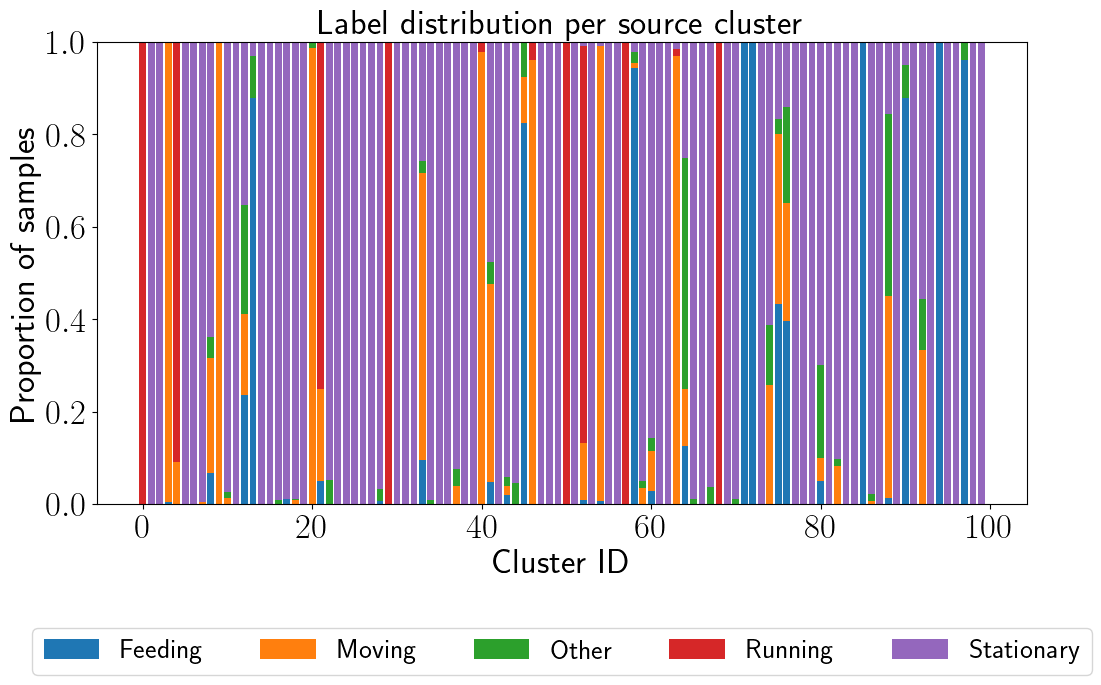

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# Build a matrix: clusters × classes
n_classes = len(np.unique(y_src))
mat = np.zeros((n_clusters, n_classes))
for ci, counter in cluster_label_counts.items():
    for cls, cnt in counter.items():
        mat[ci, cls] = cnt

# Normalize row-wise → proportions
row_sums = mat.sum(axis=1, keepdims=True)
row_sums[row_sums == 0] = 1  # avoid div by 0
mat_prop = mat / row_sums

# Plot stacked bars
fig, ax = plt.subplots(figsize=(12, 6))
bottom = np.zeros(n_clusters)
for cls in range(n_classes):
    ax.bar(range(n_clusters), mat_prop[:, cls], bottom=bottom, label=label_encoder.inverse_transform([cls])[0])
    bottom += mat_prop[:, cls]

ax.set_xlabel("Cluster ID")
ax.set_ylabel("Proportion of samples")
ax.set_title("Label distribution per source cluster")
ax.legend(loc='lower center', ncol=5, bbox_to_anchor=(0.5, -0.4))
plt.show()


In [8]:
# Extract all purities
purities = sorted([purity for (_, purity) in src_cluster_labels.values()])

In [9]:

# ----------------------------------------------------------------------------
# Step 3: Fit clustering on target (unlabeled) data 
# ----------------------------------------------------------------------------

target1_kmeans = MiniBatchKMeans(n_clusters=n_clusters, batch_size=10_000, random_state=42)
target1_kmeans.fit(X_targets[0])


target2_kmeans = MiniBatchKMeans(n_clusters=n_clusters, batch_size=10_000, random_state=42)
target2_kmeans.fit(X_targets[1])


MiniBatchKMeans(batch_size=10000, n_clusters=100, random_state=42)

In [10]:
D1 = pairwise_distances(source_kmeans.cluster_centers_, target1_kmeans.cluster_centers_)
D2 = pairwise_distances(source_kmeans.cluster_centers_, target2_kmeans.cluster_centers_)

row_ind1, col_ind1 = linear_sum_assignment(D1)
row_ind2, col_ind2 = linear_sum_assignment(D2)

mapping_target_to_source1 = {col: row for row, col in zip(row_ind1, col_ind1)}
mapping_target_to_source2 = {col: row for row, col in zip(row_ind2, col_ind2)}

In [11]:
tgt_assignments1 = target1_kmeans.predict(X_targets[0])
tgt_assignments2 = target2_kmeans.predict(X_targets[1])

tgt_labels1 = np.full(tgt_assignments1.shape[0], -1, dtype=np.int32)
tgt_labels2 = np.full(tgt_assignments2.shape[0], -1, dtype=np.int32)

tgt_conf1 = np.zeros_like(tgt_labels1, dtype=float)
tgt_conf2 = np.zeros_like(tgt_labels2, dtype=float)

purity_threshold = 0.6
for i, tci in enumerate(tgt_assignments1):
    sci = mapping_target_to_source1.get(tci, None)
    if sci is None:
        continue
    lbl, purity = src_cluster_labels[sci]
    if purity >= purity_threshold:
        tgt_labels1[i] = lbl
        tgt_conf1[i] = purity

for i, tci in enumerate(tgt_assignments2):
    sci = mapping_target_to_source2.get(tci, None)
    if sci is None:
        continue
    lbl, purity = src_cluster_labels[sci]
    if purity >= purity_threshold:
        tgt_labels2[i] = lbl
        tgt_conf2[i] = purity


V2 LABEL DISTRIBUTION
Unlabeled : 8.04
Feeding : 12.74
Moving : 7.62
Running : 4.42
Stationary : 67.19

V3 LABEL DISTRIBUTION
Unlabeled : 4.58
Feeding : 5.75
Moving : 6.38
Running : 4.23
Stationary : 79.05



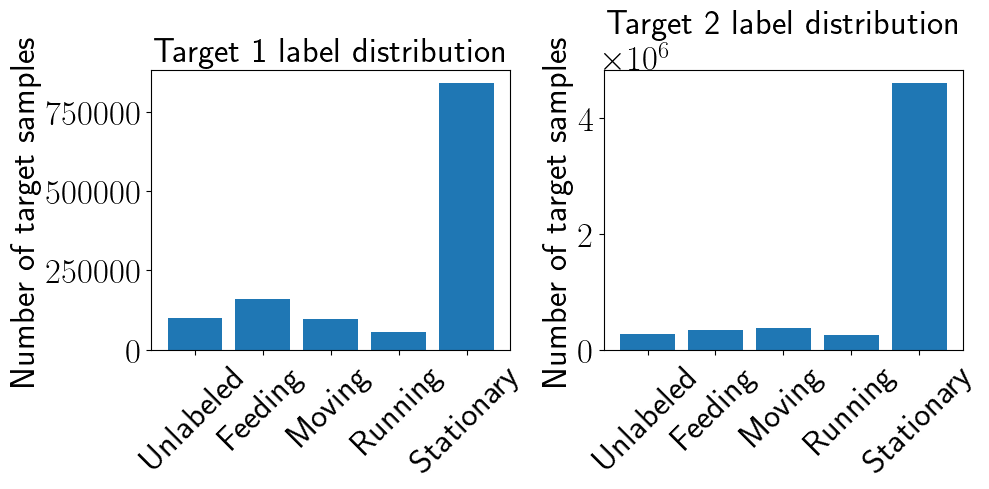

In [12]:
class_names = label_encoder.inverse_transform(np.arange(len(label_encoder.classes_)))

fig, axs = plt.subplots(1, 2, figsize=(10,5))

label_counts = Counter(tgt_labels1)
all_labels = sorted(label_counts.keys())   # includes -1
xtick_labels = []
for lbl in all_labels:
    if lbl == -1:
        xtick_labels.append("Unlabeled")
    else:
        xtick_labels.append(class_names[lbl])

counts = [label_counts[l] for l in all_labels]
axs[0].bar(range(len(all_labels)), counts)
axs[0].set_xticks(range(len(all_labels)), xtick_labels, rotation=45)
axs[0].set_ylabel("Number of target samples")
axs[0].set_title("Target 1 label distribution")

print("V2 LABEL DISTRIBUTION")
for name, count in zip(xtick_labels, counts):
    print(name, ':', np.round(100*count/sum(counts),2))
print("")

label_counts = Counter(tgt_labels2)
all_labels = sorted(label_counts.keys())   # includes -1
xtick_labels = []
for lbl in all_labels:
    if lbl == -1:
        xtick_labels.append("Unlabeled")
    else:
        xtick_labels.append(class_names[lbl])
counts = [label_counts[l] for l in all_labels]
axs[1].bar(range(len(all_labels)), counts)
axs[1].set_xticks(range(len(all_labels)), xtick_labels, rotation=45)
axs[1].set_ylabel("Number of target samples")
axs[1].set_title("Target 2 label distribution")
print("V3 LABEL DISTRIBUTION")
for name, count in zip(xtick_labels, counts):
    print(name, ':', np.round(100*count/sum(counts),2))
print("")
plt.tight_layout()
plt.show()

In [64]:
mask = (tgt_labels1 != -1)
target_labels1 = np.empty_like(tgt_labels1, dtype=object)
target_labels1[mask] = label_encoder.inverse_transform(tgt_labels1[mask])
target_labels1[~mask] = 'Unlabeled'

mask = (tgt_labels2 != -1)
target_labels2 = np.empty_like(tgt_labels2, dtype=object)
target_labels2[mask] = label_encoder.inverse_transform(tgt_labels2[mask])
target_labels2[~mask] = 'Unlabeled'

In [65]:
RVC_data = RVC_df[RVC_df.firmware_major_version == 3.0].copy()
RVC_data["behavior"] = target_labels2

In [ ]:
from src.eval.sightings import make_sightings_plots_from_labels
matched_sightings = pd.read_csv(os.path.join(io.get_data_path(), 'matched_sightings.csv'))

make_sightings_plots_from_labels(matched_sightings,
                                      RVC_data,
                                      verbose=True,
    )

Processing animal-days:   0%|          | 0/20 [00:00<?, ?it/s]

Processing animal-days: 100%|██████████| 20/20 [00:29<00:00,  1.45s/it]


0